In [1]:
import pandas_datareader as wb, pandas as pd, datetime, matplotlib.pyplot as plt, numpy as np
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2023, 5, 17)
df_null = wb.DataReader("KOSPI", "naver", start, end)
df = df_null['Close'].dropna().astype('float')

### Conditional Heteroscedastic Models

The univariate volatility models discussed in this chapter include the autoregres- sive conditional heteroscedastic (ARCH) model of Engle (1982), the generalized ARCH (GARCH) model of Bollerslev (1986), the exponential GARCH (EGARCH) model of Nelson (1991), the threshold GARCH (TGARCH) model of Glosten, Jagannathan, and Runkle (1993) and Zakoian (1994), the conditional heteroscedas- tic autoregressive moving-average (CHARMA) model of Tsay (1987), the random coefficient autoregressive (RCA) model of Nicholls and Quinn (1982), and the stochastic volatility (SV) models of Melino and Turnbull (1990), Taylor (1994), Harvey, Ruiz, and Shephard (1994), and Jacquier, Polson, and Rossi (1994). We also discuss advantages and weaknesses of each volatility model and show some applications of the models. Multivariate volatility models, including those with time-varying correlations, are discussed in Chapter 10.

#### 1. Characteristics of Vaolatility

The resulting value of σt is called the implied volatility of the underlying stock. However, this implied volatility is derived under the assumption that the price of the underlying asset follows a geometric Brownian motion. It might be different from the actual volatility. Experience shows that implied volatility of an asset return tends to be larger than that obtained by using a GARCH type of volatility model. This might be due to the risk premium for volatility or to the way daily returns are calculated. The VIX of CBOE is an implied volatility.

**Some characteristics of volatilities**
- there exist volatility clusters
- volatility evolves over time in a continuous manner
- volatility does not diverge to infinity
- volatility seems to react differently to a big price increase or a big price drop, referred to as the leverage effect

#### 2. Structure of a Model

To put the volatility models in proper perspective, it is informative to consider the conditional mean and variance of $r_t$ given $F_{t−1}$

$$\mu_t = E(r_t|F_{t-1}), ~~~~~ \sigma_t^2 = \mathrm{Var}(r_t|F_{t-1}) = E[(r_t - \mu_t)^2|F_{t-1}]$$

where $F_{t−1}$ denotes the information set available at time $t − 1$. we assume that rt follows a simple time series model such as a stationary $\mathrm{ARMA}(p, q)$ model with some explanatory variables. In other words, we entertain the model

$$r_t = \mu_t + a_t, ~~~ \mu_t = \sum_{i=1}^p \phi _i y_{t-i} - \sum_{i=1}^q \theta_i a_{t-i}, ~~~~ y_t = r_t - \phi_0 - \sum_{i=1}^k \beta_i x_{it}$$

In [3]:
ret = np.log(df) - np.log(df.shift())
ret = ret.dropna()
ret

Date
2010-01-05   -0.003260
2010-01-06    0.008657
2010-01-07   -0.012908
2010-01-08    0.006991
2010-01-11   -0.000673
                ...   
2023-05-11   -0.002210
2023-05-12   -0.006274
2023-05-15    0.001586
2023-05-16    0.000359
2023-05-17    0.005797
Name: Close, Length: 3300, dtype: float64

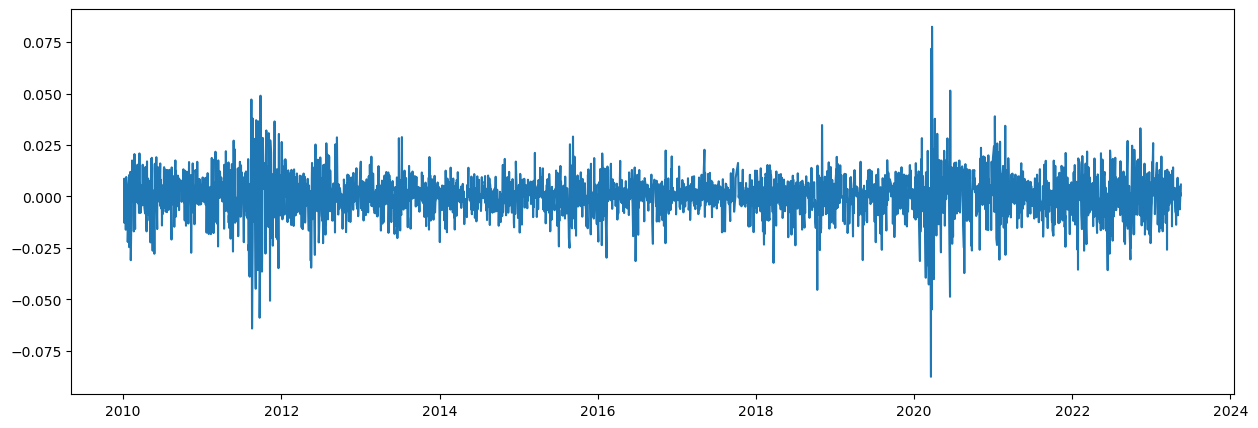

In [4]:
plt.style.use('default')
plt.figure(figsize = (15,5))
plt.plot(ret)

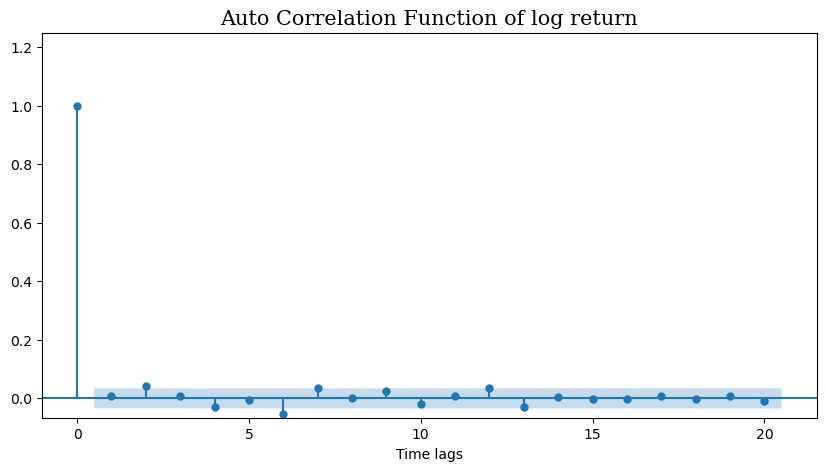

In [5]:
import statsmodels.tsa.stattools as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(ret, auto_ylims = True, lags = 20, title = 'ACF of KOSPI return' , ax = ax)
plt.xlabel('Time lags', fontsize = 10)
plt.title('Auto Correlation Function of log return', fontsize = 15, fontfamily = 'Serif')
plt.show()

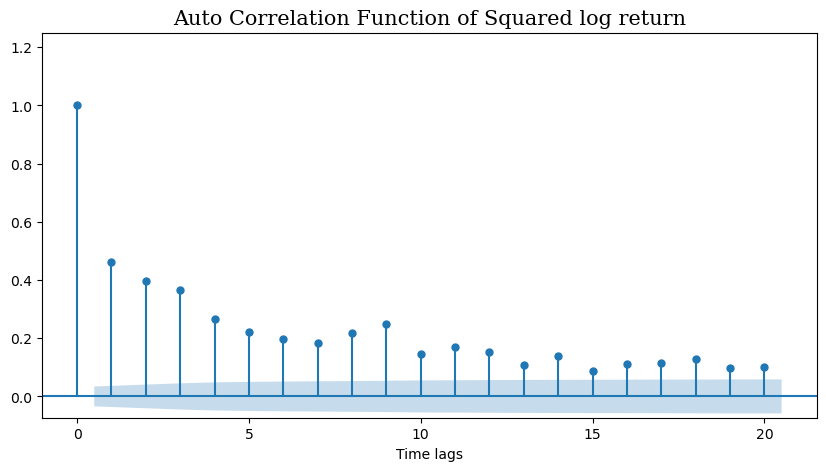

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(ret**2, auto_ylims = True, lags = 20, title = 'ACF of KOSPI return' , ax = ax)
plt.xlabel('Time lags', fontsize = 10)
plt.title('Auto Correlation Function of Squared log return', fontsize = 15, fontfamily = 'Serif')
plt.show()

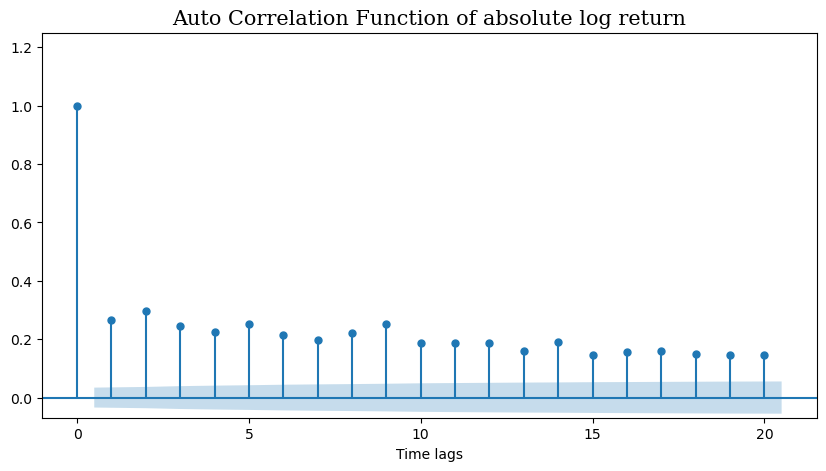

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(np.abs(ret), auto_ylims = True, lags = 20, title = 'ACF of KOSPI return' , ax = ax)
plt.xlabel('Time lags', fontsize = 10)
plt.title('Auto Correlation Function of absolute log return', fontsize = 15, fontfamily = 'Serif')
plt.show()

<Figure size 1000x800 with 0 Axes>

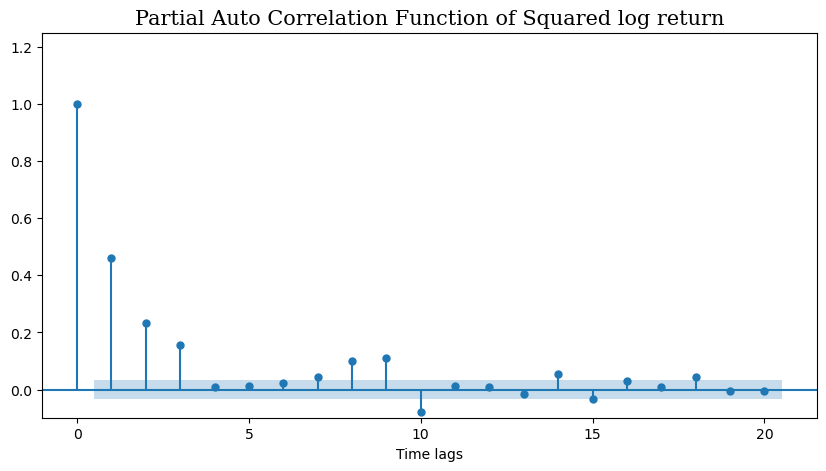

In [8]:
plt.figure(figsize = (10,8))
fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(ret**2, auto_ylims = True, lags = 20, title = 'PACF of KOSPI log Index', ax = ax)
plt.xlabel('Time lags', fontsize = 10)
plt.title('Partial Auto Correlation Function of Squared log return', fontsize = 15, fontfamily = 'Serif')
plt.show()

return이 $\mathbf{IID}$가정을 따른다면 return을 제곱하거나 절댓값을 취해도 모두 stationary 해야 한다. 그러나, 실제로 데이터를 제곱하거나 절댓값을 취하여 ACF와 PACF를 확인하면 안정시계열이 되지 않는다

Therefore, modeling conditional heteroscedasticity amounts to augmenting a dynamic equation, which governs the time evolution of the conditional variance of the asset return, to a time series model.


#### 3. Model Building
Building a volatility model for an asset return series consists of four steps

1. Specify a mean equation by testing for serial dependence in the data and, if necessary, building an econometric model (e.g.,an ARMA model) for the return series to remove any linear dependence
2. Use the residuals of the mean equation to test for ARCH effects
3. Specify a volatility model if ARCH effects are statistically significant, and perform a joint estimation of the mean and volatility equations
4. Check the fitted model carefully and refine it if necessary

**Testing for ARCH effect**

For ease in notation, let $a_t = r_t − μ_t$ be the residuals of the mean equation. The squared series $a_t^2$ is then used to check for conditional heteroscedasticity, which is also known as the $\mathrm{ARCH}$ effects

$$a_t^2 = \alpha_0 + \alpha_1 a_{t-1}^2 + \cdots + \alpha_m a_{t-m}^2 + e_t, ~~~~~~ t = m+1, \cdots, T$$

 the null hypothesis is $H_0 : α_1 = \cdots = α_m = 0$. Let $\mathrm{SSR}_0$ Let $\mathrm{SSR}_0 = \sum^T_{t=m+1}(a_t^2 − \bar{ω})^2$, where $\bar{ω} = \frac{1}{T} \sum_{t=1}^T a_t^2$ is the sample mean of $a_t^2$, and $\mathrm{SSR}_1 = \sum^T_{t=m+1} \hat{e}_t^2$, where $\hat{e}_t$ is the least-squares residual of the prior linear regression. Then we have

$$F = \frac{(\mathrm{SSR}_0 - \mathrm{SSR}_1) / m}{\mathrm{SSR}_1 / (T - 2m - 1)}$$

which is asymptotically distributed as a chi-squared distribution with m degrees of freedom under the null hypothesis. The decision rule is to reject the null hypothesis if $F > χ_m^2(α)$, where $χ_m^2(α)$ is the upper $100(1 − α)$th percentile of $χ_m^2$ , or the $p$ value of $F$ is less than $α$, type-I error.

#### 4. The ARCH Model
The first model that provides a systematic framework for volatility modeling is the ARCH model of Engle (1982). The basic idea of ARCH models is that (a) the shock at of an asset return is serially uncorrelated, but dependent, and (b) the dependence of at can be described by a simple quadratic function of its lagged values. Specifically, an $\mathrm{ARCH}(m)$ model assumes that

$$a_t = σ_t\epsilon_t, ~~~~~~ σ_t^2 = α_0 +α_1a_{t−1}^2 +···+α_ma_{t−m}^2$$

In [9]:
import statsmodels.api as sm
model = sm.tsa.ARIMA(np.log(df), order = (1,0,0), trend = 'c').fit(method = 'innovations_mle')
model.summary()

/Users/tommylee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tommylee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tommylee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 3301
Model:                 ARIMA(1, 0, 0)   Log Likelihood               10374.211
Date:                Fri, 02 Jun 2023   AIC                         -20742.422
Time:                        16:17:25   BIC                         -20724.116
Sample:                             0   HQIC                        -20735.870
                               - 3301                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.6639      0.071    108.585      0.000       7.526       7.802
ar.L1          0.9978      0.001    986.761      0.000       0.996       1.000
sigma2         0.0001   1.33e-06     81.752      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):              5376.44
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                            -0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

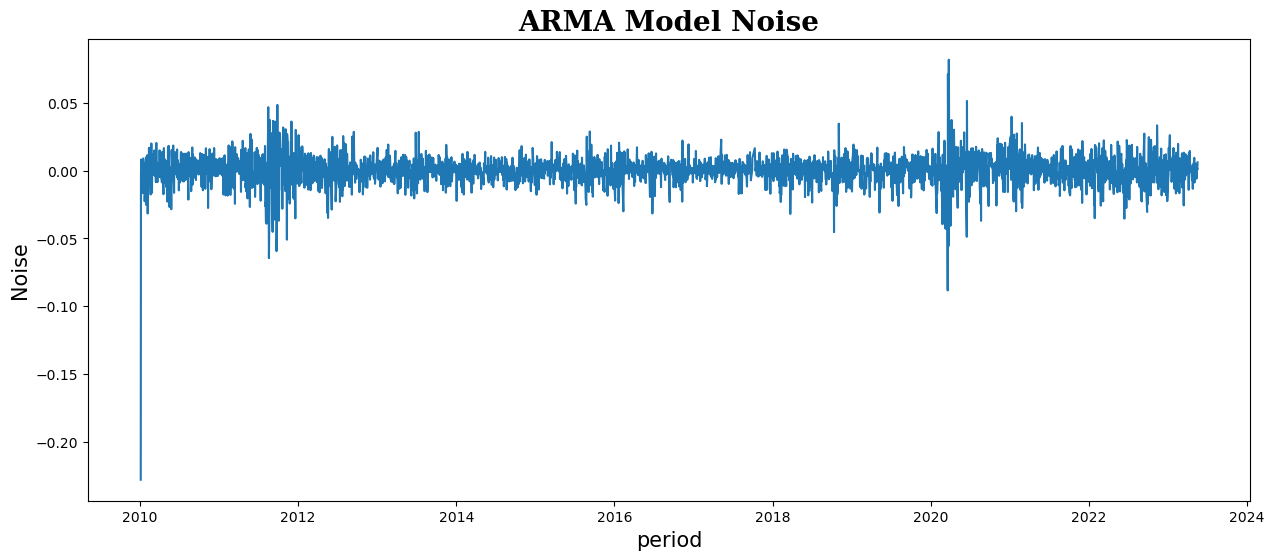

In [10]:
noise = model.resid

plt.figure(figsize = (15,6))
plt.title('ARMA Model Noise', fontsize = 20, fontweight='bold', fontfamily='Serif')
plt.xlabel('period', fontsize = 15)
plt.ylabel('Noise', fontsize = 15)
plt.plot(noise)
plt.show()

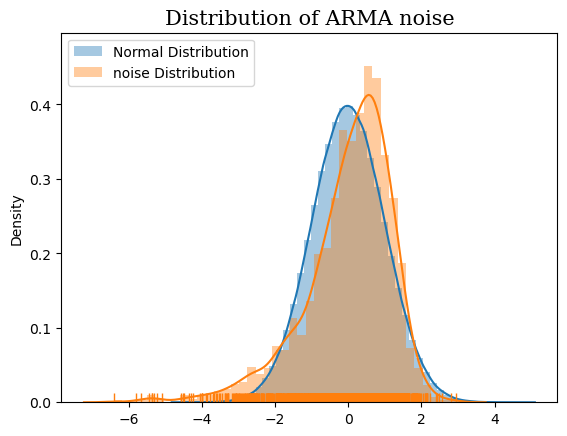

In [11]:
import seaborn as sns
sns.distplot(np.random.normal(size=1000000), kde = True, label = 'Normal Distribution')
sns.distplot(np.log(noise) - np.mean(np.log(noise)), kde = True, rug = True, label = 'noise Distribution')
plt.title('Distribution of ARMA noise', fontsize = 15, fontfamily = 'Serif')
plt.legend()
plt.show()

ARMA의 noise는 정규분포에 가까워야 잘 추정된 모델이라고 할 수 있다

In [12]:
import arch
ARCH = arch.arch_model(noise, vol = 'arch', p = 1).fit()
ARCH.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 38631896372.38814
Iteration:      2,   Func. Count:     17,   Neg. LLF: -10558.003707355707
Optimization terminated successfully    (Exit mode 0)
            Current function value: -10558.003708677905
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                10558.0
Distribution:                  Normal   AIC:                          -21110.0
Method:            Maximum Likelihood   BIC:                          -21091.7
                                        No. Observations:                 3301
Date:                Fri, Jun 02 2023   Df Residuals:                     3300
Time:                        16:17:29   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         3.2345e-04  1.658e-04      1.950  5.114e-02 [-1.602e-06,6.485e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      7.4734e-05  3.302e-06     22.632 2.084e-113 [6.826e-05,8.121e-05]
alpha[1]       0.4000  7.529e-02      5.313  1.078e-07     [  0.252,  0.548]
============================================================================

Covariance estimator: robust
"""

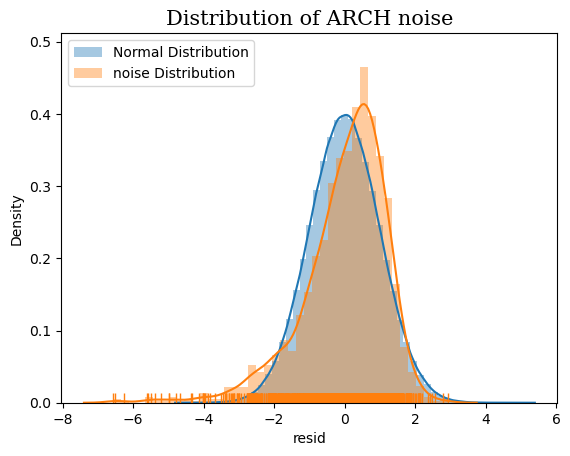

In [13]:
sns.distplot(np.random.normal(size=1000000), kde = True, label = 'Normal Distribution')
sns.distplot(np.log(ARCH.resid) - np.mean(np.log(ARCH.resid)), kde = True, rug = True, label = 'noise Distribution')
plt.title('Distribution of ARCH noise', fontsize = 15, fontfamily = 'Serif')
plt.legend()
plt.show()

**4.1 Properties of ARCH Models**

To understand the $\mathrm{ARCH}$ models, it pays to carefully study the $\mathrm{ARCH}(1)$ model
$$a_t = \sigma_t \epsilon_t, ~~~~~~ \sigma_t^2 = \alpha_0 + \alpha_1 a_{t-1}^2$$

where $α_0 > 0$ and $α_1 ≥ 0$. First, the unconditional mean of at remains zero because

$$E(a_t ) = E[E(a_t |F_{t−1})] = E[σ_t E(\epsilon_t)] = 0$$

Second, the unconditional variance of at can be obtained as

$$\mathrm{Var}(a_t) = E(a_t^2) = E[E(a_t^2 | F_{t-1})] = E(\alpha_0 + \alpha_1 a_{t-1}^2 = \alpha_0 + \alpha_1 E(a_{t-1}^2)$$

Therefore, we have $\mathrm{Var}(a_t) = α_0 + α_1 \mathrm{Var}(at)$ and $\mathrm{Var}(a_t) = α_0 /(1 − α_1)$

**4.2 Weaknesses of ARCH Models**

The advantages of $\mathrm{ARCH}$ models include properties discussed in the previous section. The model also has some weaknesses
1. The model assumes that positive and negative shocks have the same effects on volatility because it depends on the square of the previous shocks. In practice, it is well known that the price of a financial asset responds differently to positive and negative shocks.
2. The $\mathrm{ARCH}$ model is rather restrictive. For instance, $α_1^2$ of an $\mathrm{ARCH}(1)$ model must be in the interval $[0, \frac{1}{3}]$ if the series has a finite fourth moment. The constraint becomes complicated for higher order $\mathrm{ARCH}$ models. In practice,
it limits the ability of ARCH models with Gaussian innovations to capture excess kurtosis.
3. The $\mathrm{ARCH}$ model does not provide any new insight for understanding the source of variations of a financial time series. It merely provides a mechanical way to describe the behavior of the conditional variance. It gives no indication about what causes such behavior to occur.
4. $\mathrm{ARCH}$ models are likely to overpredict the volatility because they respond slowly to large isolated shocks to the return series.

#### 5. The GARCH Model

Although the ARCH model is simple, it often requires many parameters to adequately describe the volatility process of an asset return. For a log return series $r_t$ , let $a_t = r_t − μ_t$ be the innovation at time $t$. Then $a_t$ follows a $\mathrm{GARCH}(m, s)$ model if

$$a_t = \sigma_t \epsilon_t, ~~~~~~ \sigma_t^2 = \alpha_0 + \sum_{i=1}^m \alpha_i a_{t-i}^2 + \sum_{j=1}^s \beta_j \sigma_{t-j}^2$$

To understand properties of $\mathrm{GARCH}$ models, it is informative to use the fol- lowing representation. Let $η_t = a_t^2 − σ_t^2$ so that $σ_t^2 = a_t^2 − η_t$. we can rewrite the GARCH model as

$$a_t^2 = \alpha_0 + \sum_{i=1}^{\max (m,s)}(\alpha_i + \beta_i) a_{t-i}^2 + \eta_t - \sum_{j=1}^s \beta_j \eta_{t-j}$$

**5.1 An Illustrative Example**

$a_t = r_t - \mu_t$를 다음과 같이 구현한다

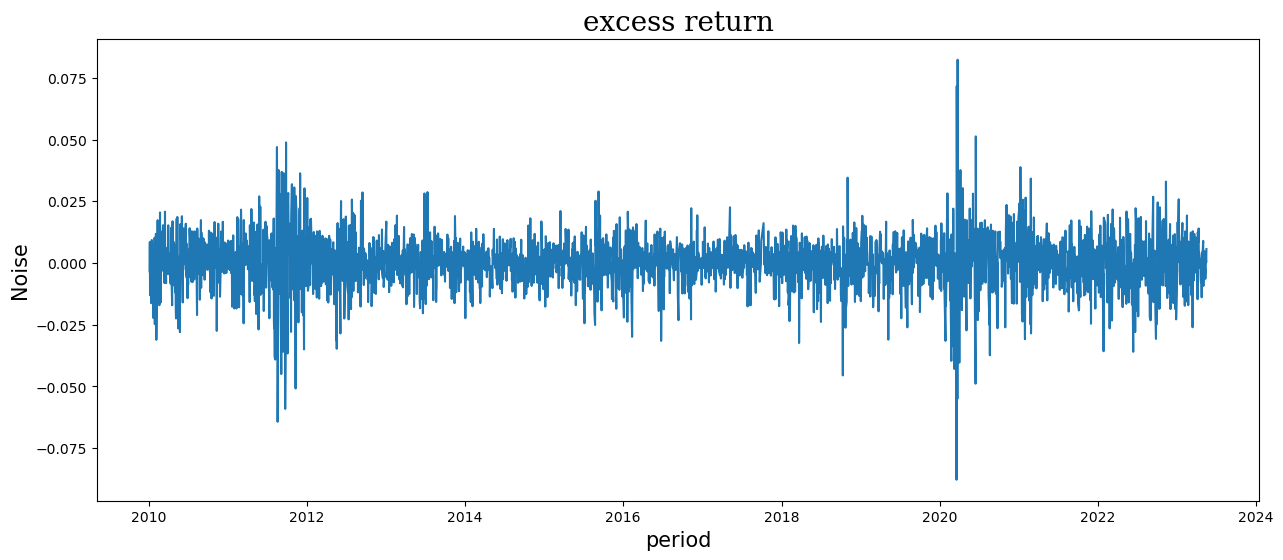

In [14]:
a = ret - np.mean(ret)

plt.figure(figsize = (15,6))
plt.title('excess return', fontsize = 20, fontfamily='Serif')
plt.xlabel('period', fontsize = 15)
plt.ylabel('Noise', fontsize = 15)
plt.plot(a)
plt.show()

$a_t = \sigma_t \epsilon_t$로 가정한다. 이중 $\sigma^2_t$에 대해 다음과 같은 관계식을 가진다

$$\sigma_t^2 = \alpha_0 + \sum_{i=1}^m \alpha_i a_{t-i}^2 + \sum_{j=1}^s \beta_j \sigma_{t-j}^2$$

In [15]:
garch_model = arch.arch_model(ret, p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist = 'normal')

model = garch_model.fit(disp='off')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                10814.9
Distribution:                  Normal   AIC:                          -21621.9
Method:            Maximum Likelihood   BIC:                          -21597.4
                                        No. Observations:                 3300
Date:                Fri, Jun 02 2023   Df Residuals:                     3299
Time:                        16:17:31   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         2.5238e-04  5.220e-06     48.351      0.000 [2.421e-04,2.626e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.1804e-06  1.020e-11  2.138e+05      0.000 [2.180e-06,2.180e-06]
alpha[1]       0.1000  1.429e-02      6.999  2.583e-12   [7.200e-02,  0.128]
beta[1]        0.8800  1.168e-02     75.373      0.000     [  0.857,  0.903]
============================================================================

Covariance estimator: robust
"""

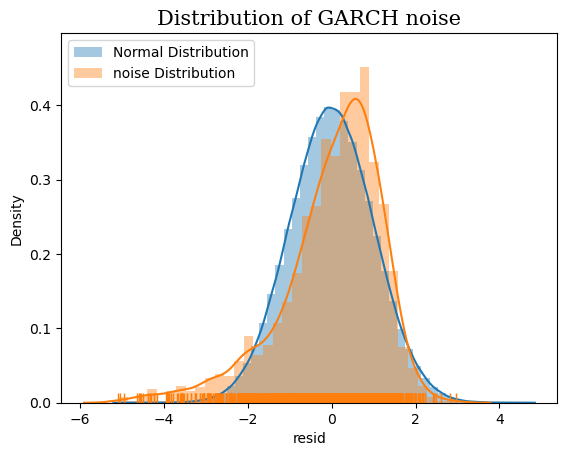

In [16]:
sns.distplot(np.random.normal(size=1000000), kde = True, label = 'Normal Distribution')
sns.distplot(np.log(model.resid) - np.mean(np.log(model.resid)), kde = True, rug = True, label = 'noise Distribution')
plt.title('Distribution of GARCH noise', fontsize = 15, fontfamily = 'Serif')
plt.legend()
plt.show()

KOSPI 일별 return에 대해 적합화한 결과 아래와 같은 결과가 나왔다

$$\sigma_t^2 = 2.1804 \times 10^{-6} + 0.1 a_{t-1}^2 + 0.88 \sigma_{t-1}^2$$

주의 : $\alpha$와 $\beta$의 coefficient의 합은 1이 넘지 말아야 한다

#### 6. The Integrated GARCH Model

If the AR polynomial of the $\mathrm{GARCH}$ representation has a unit root, then we have an $\mathrm{IGARCH}$ model. Thus, $\mathrm{IGARCH}$ models are unit-root $\mathrm{GARCH}$ models. Similar to $\mathrm{ARIMA}$ models, a key feature of $\mathrm{IGARCH}$ models is that the impact of past squared shocks $η_{t−i} = a^2_{t-i} −σ^2_{t-i}$ for $i>0$ on $a_t^2$ is persistent.

An $\mathrm{IGARCH(1,1)}$ model can be written as

$$a_t = \sigma_t \epsilon_t, ~~~~~~ \sigma_t^2 = \alpha_0 + \beta_1 \sigma_{t-1}^2 + (1-\beta_1)a_{t-1}^2$$

In [17]:
Igarch_model = arch.arch_model(ret, p = 1, q = 1, mean = 'constant', vol = 'GARCH', power = 1.0, dist = 'normal')

model = Igarch_model.fit(disp='off')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Constant Mean - AVGARCH Model Results                     
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                    AVGARCH   Log-Likelihood:                10813.9
Distribution:                  Normal   AIC:                          -21619.8
Method:            Maximum Likelihood   BIC:                          -21595.3
                                        No. Observations:                 3300
Date:                Fri, Jun 02 2023   Df Residuals:                     3299
Time:                        16:17:33   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         2.5249e-04  1.476e-04      1.711  8.712e-02 [-3.677e-05,5.417e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.7572e-04  7.795e-05      3.537  4.043e-04 [1.229e-04,4.285e-04]
alpha[1]       0.1024  1.441e-02      7.103  1.218e-12   [7.412e-02,  0.131]
beta[1]        0.8929  1.738e-02     51.376      0.000     [  0.859,  0.927]
============================================================================

Covariance estimator: robust
"""

$\mathrm{IGARCH}$는 위와같이 arch_model 함수에서 power argument를 조정하므로써 계산 가능하다

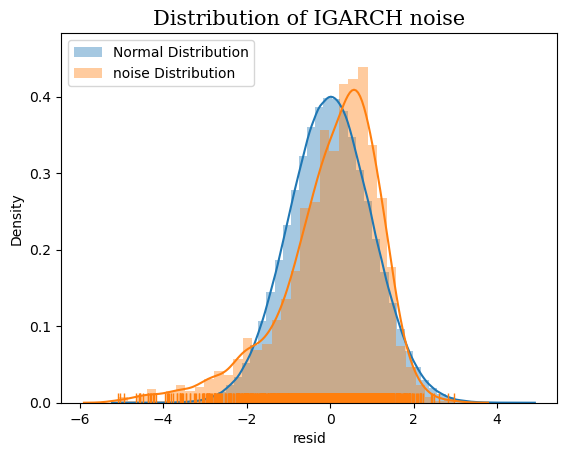

In [18]:
sns.distplot(np.random.normal(size=1000000), kde = True, label = 'Normal Distribution')
sns.distplot(np.log(model.resid) - np.mean(np.log(model.resid)), kde = True, rug = True, label = 'noise Distribution')
plt.title('Distribution of IGARCH noise', fontsize = 15, fontfamily = 'Serif')
plt.legend()
plt.show()

#### 7. The GARCH-M model

In finance, the return of a security may depend on its volatility. To model such a phenomenon, one may consider the $\mathrm{GARCH-M}$ model, where M stands for $\mathrm{GARCH}$ in the mean. A simple $\mathrm{GARCH-M(1,1)}$ model can be written as

$$r_t = \mu + c \sigma_t^2 +a_t, ~~~~~ a_t = \sigma_t \epsilon_t$$
$$\sigma_t^2 = \alpha_0 + \alpha_1 a_{t-1}^2 + \beta_1 \sigma_{t-1}^2$$

In [29]:
model = arch.arch_model(ret, p = 1, q = 1, vol = 'Garch', mean = 'AR', dist = 'Normal')
result = model.fit()
result.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 241483405484.2676
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1141095.3645931692
Iteration:      3,   Func. Count:     31,   Neg. LLF: 178368397.8915336
Iteration:      4,   Func. Count:     44,   Neg. LLF: 9.453734287839795e+17
Iteration:      5,   Func. Count:     59,   Neg. LLF: 6830774879.525677
Iteration:      6,   Func. Count:     72,   Neg. LLF: 268719339625675.4
Iteration:      7,   Func. Count:     87,   Neg. LLF: 5786684304.415165
Iteration:      8,   Func. Count:    100,   Neg. LLF: 179228633756163.0
Iteration:      9,   Func. Count:    114,   Neg. LLF: -10814.926933897848
Optimization terminated successfully    (Exit mode 0)
            Current function value: -10814.926933397652
            Iterations: 13
            Function evaluations: 114
            Gradient evaluations: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                10814.9
Distribution:                  Normal   AIC:                          -21621.9
Method:            Maximum Likelihood   BIC:                          -21597.4
                                        No. Observations:                 3300
Date:                Fri, Jun 02 2023   Df Residuals:                     3299
Time:                        16:45:27   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
Const      2.5238e-04  5.220e-06     48.351      0.000 [2.421e-04,2.626e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.1804e-06  1.020e-11  2.138e+05      0.000 [2.180e-06,2.180e-06]
alpha[1]       0.1000  1.429e-02      6.999  2.583e-12   [7.200e-02,  0.128]
beta[1]        0.8800  1.168e-02     75.373      0.000     [  0.857,  0.903]
============================================================================

Covariance estimator: robust
"""

#### 8. The Exponential GARCH model

To overcome some weaknesses of the GARCH model in handling financial time series, Nelson (1991) proposes the exponential $\mbox{GARCH}$ ($\mbox{EGARCH}$) model. In particular, to allow for asymmetric effects between positive and negative asset returns, he considered the weighted innovation
$$g(\epsilon_t) = \theta \epsilon_t + \gamma [|\epsilon_t| - E(|\epsilon _t|)]$$

where $θ$ and $γ$ are real constants. Both $\epsilon_t$ and $|\epsilon_t | − E(|\epsilon_t |)$ are zero-mean iid sequences with continuous distributions. Therefore, $E[g(\epsilon_t)] = 0$. The asymmetry of $g(\epsilon_t)$ can easily be seen by rewriting it as

$$g(\epsilon_t) = \begin{cases}
(\theta + \gamma)\epsilon_t - \gamma E(|\epsilon_t|) ~~~~& \mbox{if } \epsilon_t \geq 0, \\
(\theta - \gamma)\epsilon_t - \gamma E(|\epsilon_t|) ~~~~ & \mbox{if } \epsilon_t < 0,
\end{cases}$$

An $\mbox{EGARCH}(m,s)$ model can be written as

$$a_t = \sigma_t \epsilon_t, ~~~~~ \ln (\sigma_t^2) = \alpha_0 + \frac{1+\beta_1 B + \cdots + \beta_{s-1}B^{s-1}}{1 - \alpha_1 B - \cdots - \alpha_m B^m}g(\epsilon_{t-1})$$

To better understand the $\mbox{EGARCH}$ model, let us consider the simple model with order (1,1)

$$a_t = \sigma_t \epsilon_t, ~~~~~~ (1 - \alpha B) \ln(\sigma_t^2) = (1-\alpha) \alpha_0 + g(\epsilon_{t-1})$$

In this
case, $E(|\epsilon_t|) = \sqrt{\frac{2}{π}}$ and the model for $\ln(σ_t^2)$ becomes

$$(1 - \alpha B) \ln(\sigma_t^2) = \begin{cases}
\alpha_* + (\gamma + \theta) \epsilon_{t-1} ~~~~& \mbox{if } \epsilon_t \geq 0, \\
\alpha_* + (\gamma - \theta) (-\epsilon_{t-1}) ~~~~ & \mbox{if } \epsilon_t < 0,
\end{cases}$$

In [30]:
model = arch.arch_model(ret, vol = 'EGARCH', p = 1, q = 1)
result = model.fit()
result.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 9.133094471877135e+20
Iteration:      2,   Func. Count:     19,   Neg. LLF: 11494.230080677851
Iteration:      3,   Func. Count:     28,   Neg. LLF: 95465625079.66412
Iteration:      4,   Func. Count:     38,   Neg. LLF: -6006.308101156779
Iteration:      5,   Func. Count:     46,   Neg. LLF: -10813.332059120034
Iteration:      6,   Func. Count:     51,   Neg. LLF: -10813.333181571697
Iteration:      7,   Func. Count:     56,   Neg. LLF: -10813.33318442174
Iteration:      8,   Func. Count:     60,   Neg. LLF: -10813.333184407806
Optimization terminated successfully    (Exit mode 0)
            Current function value: -10813.33318442174
            Iterations: 8
            Function evaluations: 60
            Gradient evaluations: 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - EGARCH Model Results                     
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                10813.3
Distribution:                  Normal   AIC:                          -21618.7
Method:            Maximum Likelihood   BIC:                          -21594.3
                                        No. Observations:                 3300
Date:                Fri, Jun 02 2023   Df Residuals:                     3299
Time:                        16:45:32   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         2.5527e-04  1.464e-04      1.744  8.123e-02 [-3.168e-05,5.422e-04]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega         -0.2455  7.287e-02     -3.369  7.539e-04 [ -0.388, -0.103]
alpha[1]       0.1915  2.728e-02      7.019  2.236e-12 [  0.138,  0.245]
beta[1]        0.9731  7.860e-03    123.801      0.000 [  0.958,  0.988]
========================================================================

Covariance estimator: robust
"""

#### 9. The Threshold GARCH model
Another volatility model commonly used to handle leverage effects is the threshold $\mbox{GARCH}$ (or $\mbox{TGARCH}$) model; see Glosten, Jagannathan, and Runkle (1993) and Zakoian (1994). A TGARCH(m,s) model assumes the form

$$\sigma_t^2 = \alpha_0 + \sum_{i=1}^s (\alpha_i = \gamma_i N_{t-i}a_{t-i}^2 + \sum_{j=1}^m \beta_j \sigma_{t-j}^2)$$

where $N_{t-i}$ is an indicator for negative $a_{t-i}$, that is,

$$N_{t-i} = \begin{cases}
1 ~~~~& \mbox{if } a_{t-i} < 0, \\
0 ~~~~ & \mbox{if } a_{t-i} \geq 0,
\end{cases}$$


In [32]:
model = arch.arch_model(ret, vol='Garch', p=1, q=1, o=1) # parameter 'o' means threshold variables
result = model.fit()
result.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 14098699184.090696
Iteration:      2,   Func. Count:     21,   Neg. LLF: 610400.543440896
Optimization terminated successfully    (Exit mode 0)
            Current function value: -10844.217284808325
            Iterations: 3
            Function evaluations: 31
            Gradient evaluations: 2


<class 'statsmodels.iolib.summary.Summary'>
"""
                   Constant Mean - GJR-GARCH Model Results                    
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                10844.2
Distribution:                  Normal   AIC:                          -21678.4
Method:            Maximum Likelihood   BIC:                          -21647.9
                                        No. Observations:                 3300
Date:                Fri, Jun 02 2023   Df Residuals:                     3299
Time:                        16:50:41   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         7.0828e-05  1.499e-04      0.472      0.637 [-2.230e-04,3.647e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.1800e-06  2.685e-14  8.119e+07      0.000 [2.180e-06,2.180e-06]
alpha[1]       0.0500  1.608e-02      3.110  1.870e-03 [1.849e-02,8.151e-02]
gamma[1]       0.1000  1.535e-02      6.513  7.386e-11   [6.991e-02,  0.130]
beta[1]        0.8800  7.632e-03    115.306      0.000     [  0.865,  0.895]
============================================================================

Covariance estimator: robust
"""

#### 10. The CHARMA model

Many other econometric models have been proposed in the literature to describe the evolution of the conditional variance $σ_t^2$. We mention the conditional heteroscedastic $\mbox{ARMA (CHARMA)}$ model that uses random coefficients to produce conditional heteroscedasticity; see Tsay (1987). The $\mbox{CHARMA}$ model is not the same as the $\mbox{ARCH}$ model, but the two models have similar second-order conditional properties. A $\mbox{CHARMA}$ model is defined as

$$r_t = \mu_t + a_t,~~~~~~ a_t = \delta_{1t}a_{t-1} + \delta_{2t}a_{t-2} + \cdots +\delta{mt}a_{t-m} + \eta _t$$

<AxesSubplot:xlabel='Date'>

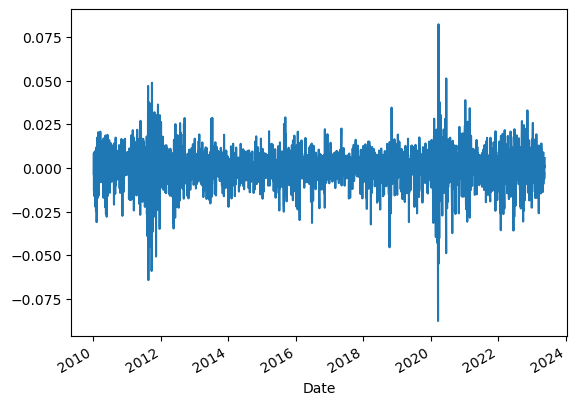

In [42]:
a.plot()

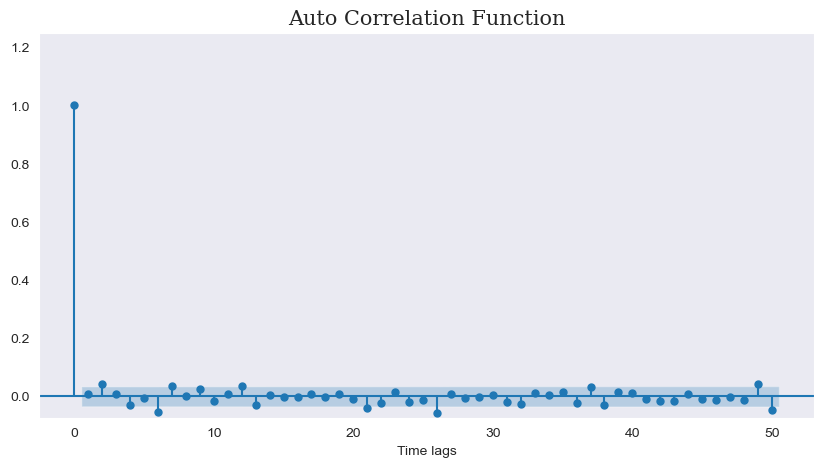

In [47]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(a, auto_ylims = True, lags = 50, title = 'ACF of KOSPI return' , ax = ax)
plt.xlabel('Time lags', fontsize = 10)
plt.title('Auto Correlation Function', fontsize = 15, fontfamily = 'Serif')
plt.show()

In [40]:
def charma_model(ret, p = 1, d = 0, q = 0, trend = 'c', method = 'innovations_mle') :
    a = ret - np.mean(ret)
    import statsmodels.api as sm
    model = sm.tsa.ARIMA(a, order = (p,d,q), trend = trend).fit(method = method)
    return model

charma_model = charma_model(ret, p = 10, d = 0, q = 0, trend = 'c')
charma_model.summary()

/Users/tommylee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tommylee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tommylee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 3300
Model:                ARIMA(10, 0, 0)   Log Likelihood               10385.195
Date:                Fri, 02 Jun 2023   AIC                         -20746.391
Time:                        17:13:08   BIC                         -20673.171
Sample:                             0   HQIC                        -20720.181
                               - 3300                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.084e-09      0.000     -4e-05      1.000      -0.000       0.000
ar.L1          0.0084      0.009      0.919      0.358      -0.010       0.026
ar.L2          0.0412      0.009      4.532      0.000       0.023       0.059
ar.L3          0.0104      0.010      1.024      0.306      -0.009       0.030
ar.L4         -0.0294      0.012     -2.458      0.014      -0.053      -0.006
ar.L5         -0.0054      0.012     -0.444      0.657      -0.029       0.018
ar.L6         -0.0519      0.012     -4.181      0.000      -0.076      -0.028
ar.L7          0.0354      0.012      2.939      0.003       0.012       0.059
ar.L8          0.0061      0.012      0.513      0.608      -0.017       0.029
ar.L9          0.0245      0.011      2.182      0.029       0.002       0.047
ar.L10        -0.0221      0.012     -1.783      0.075      -0.046       0.002
sigma2         0.0001    1.4e-06     77.087      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5100.46
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""